# Description
Trying to draw lines to make 2d topographic maps. Tried using closed splines... Didn't work too well actually... There aren't enough interpolation libraries for Julia quite yet so nothing had exactly what I was looking for.

In [1]:
using Plots
using Gnuplot
using Dierckx
using Interpolations

In [2]:
Gnuplot.options.term = "pngcairo"

"pngcairo"

In [14]:
include("../../src/triangles_hgt.jl")
include("../../src/parse_hgt.jl")
include("../../src/slicing.jl")
include("../../src/stl_format.jl")

write_stl_binary (generic function with 1 method)

In [4]:
function get_edge(layer::Array{Array{Int64,1},1})
    edges = Array{Array{Int64,1},1}(undef,0)
    for pt in layer
        (i,j) = pt

        
        layer_arr = Array{Bool,2}(undef,size(sliced_data)...)
        layer_arr[:,:] .= false

        for el in layer
            layer_arr[el[1],el[2]] = true
        end
        
        n_adj = 0
        if layer_arr[i+1,j]
            n_adj+=1
        end
        if layer_arr[i-1,j]
            n_adj+=1
        end
        if layer_arr[i,j+1]
            n_adj+=1
        end
        if layer_arr[i,j-1]
            n_adj+=1
        end
    
        if n_adj < 4
            push!(edges,pt)
        end
    end
    return edges
end

get_edge (generic function with 1 method)

In [5]:
function centroid(xs,ys)
    return sum(xs)/length(xs),sum(ys)/length(ys)
end

centroid (generic function with 1 method)

In [6]:
function cartesian_to_polar(x,y)
    theta = atan(y,x)

    sqrt(x*x + y*y),theta
end

cartesian_to_polar (generic function with 1 method)

In [7]:
function polar_to_cartesian(r,theta)
    r*cos(theta),r*sin(theta)
end

polar_to_cartesian (generic function with 1 method)

In [8]:
function is_within_circle(point::Array{Float64,1},center::Array{Float64,1},radius::Float64)
    x,y = point
    cx,cy = center
    return (x-cx)*(x-cx) + (y-cy)*(y-cy) < radius*radius
end

is_within_circle (generic function with 1 method)

In [9]:
function integer_values_within_circle(center::Array{Float64,1},radius::Float64,map_size::Int64)
    square = Array{Array{Float64},1}(undef,0)
    cx,cy = center
    for i in 1:map_size
        for j in 1:map_size
            if (i-cx)*(i-cx) + (j-cy)*(j-cy) < radius*radius
                push!(square,[i,j])
            end
        end
    end
    return square
end

integer_values_within_circle (generic function with 1 method)

In [10]:
function pathfinder(starting_point::Array{Float64,1},starting_dir::Float64, point_map::Array{Int64,2})
    sx,sy = starting_point
    int_circ = integer_values_within_circle([sx,sy],rad,box_size)
    for ic_val in int_circ
        for pm_val in point_map
            if ic_val == pm_val
                pushpm_val
            end
        end
    end
end

pathfinder (generic function with 1 method)

In [15]:
center = [35.362729, 138.730627] # Mt. Fuji
box_size = 300 # size in integer arcsec
coords = center_bounds_coords(center,box_size,box_size)
filename = get_filename_from_coords(center,"../../hgt_data/")
data = parse_hgt(filename)
println(filename)

sliced_data = slice_data(data,coords)

../../hgt_data/n35e138.hgt
Slice indicies [1157, 1457, 2481, 2781]


301×301 Array{Int16,2}:
 1321  1328  1333  1336  1338  1341  …  1627  1623  1620  1618  1616  1616
 1324  1330  1336  1339  1342  1343     1629  1626  1624  1621  1619  1615
 1325  1332  1338  1343  1344  1346     1634  1633  1630  1627  1622  1616
 1327  1331  1337  1342  1345  1347     1639  1637  1634  1630  1624  1618
 1329  1332  1336  1342  1345  1349     1643  1641  1637  1631  1625  1621
 1335  1335  1338  1344  1348  1352  …  1646  1644  1641  1634  1628  1624
 1338  1340  1342  1345  1349  1353     1648  1646  1643  1639  1633  1630
 1338  1342  1345  1349  1352  1356     1653  1650  1646  1643  1641  1638
 1340  1342  1346  1350  1354  1358     1659  1657  1652  1649  1648  1645
 1341  1344  1347  1351  1354  1357     1665  1662  1659  1657  1656  1652
 1342  1344  1348  1353  1356  1358  …  1668  1665  1664  1663  1662  1657
 1343  1346  1350  1355  1359  1359     1673  1671  1669  1670  1669  1665
 1347  1348  1351  1355  1358  1360     1681  1680  1677  1676  1675  1673
 

In [21]:
layer_height=100
delta = maximum(sliced_data)-minimum(sliced_data)
offset = minimum(sliced_data)
n_layers = trunc(delta/layer_height)+1
for k in 1:convert(Int64,n_layers)
    for (i,el) in enumerate(sliced_data)
        if offset+layer_height*(k-1) <= el < offset+layer_height*k  
            flattened_val = offset+layer_height*(k-1)
            sliced_data[i] = flattened_val
        end
    end
end

In [22]:
layers = Array{Array{Array{Int64,1},1},1}(undef,convert(Int64,n_layers))
for i in 1:convert(Int64,n_layers)
    layers[i] = Array{Array{Int64,1},1}(undef,0)
end

for k in 1:convert(Int64,n_layers)
    for i in 1:size(sliced_data,1)
        for j in 1:size(sliced_data,2)
            if offset+layer_height*(k-1) <= sliced_data[i,j] < offset+layer_height*k  
                push!(layers[k],[i,j])
            end
        end
    end
end

In [23]:
layer_num=20
#edge = get_edge(layers[layer_num])
stacked_layers = vcat(layers[layer_num:end]...)
edge = get_edge(stacked_layers)

267-element Array{Array{Int64,1},1}:
 [111, 154]
 [111, 155]
 [111, 156]
 [111, 157]
 [111, 158]
 [111, 159]
 [111, 160]
 [111, 161]
 [111, 162]
 [111, 163]
 [111, 164]
 [111, 165]
 [111, 166]
 ⋮
 [195, 154]
 [195, 155]
 [195, 156]
 [195, 157]
 [195, 158]
 [195, 160]
 [195, 161]
 [195, 162]
 [195, 163]
 [195, 164]
 [195, 165]
 [195, 166]

In [26]:
points = edge
x = [i for (i,j) in points]
y = [j for (i,j) in points]
x_cent,y_cent = centroid(x,y)

x_trans = [i-x_cent for (i,j) in points]
y_trans = [j-y_cent for (i,j) in points]

edge_polar = Array{Array{Float64,1},1}(undef,length(points))
for (i,(xt,yt)) in enumerate(zip(x_trans,y_trans))
    edge_polar[i] = collect(cartesian_to_polar(xt,yt))
end
edge_polar = transpose(hcat(edge_polar...))
edge_polar_sorted = edge_polar[sortperm(edge_polar[:, 2]), :]

edge_sorted_cartesian = Array{Array{Float64,1},1}(undef,length(points))
for (i,(r,theta)) in enumerate(eachrow(edge_polar_sorted))
    cart_x,cart_y = polar_to_cartesian(r,theta)
    edge_sorted_cartesian[i] = [x_cent+ cart_x,y_cent + cart_y]
end

edge_sorted_cartesian = transpose(hcat(edge_sorted_cartesian...))

267×2 Transpose{Float64,Array{Float64,2}}:
 112.0  151.0
 112.0  150.0
 112.0  149.0
 112.0  148.0
 112.0  147.0
 112.0  146.0
 112.0  145.0
 112.0  144.0
 113.0  143.0
 113.0  142.0
 113.0  141.0
 113.0  140.0
 113.0  139.0
   ⋮    
 111.0  163.0
 111.0  162.0
 111.0  161.0
 111.0  160.0
 111.0  159.0
 111.0  158.0
 111.0  157.0
 111.0  156.0
 111.0  155.0
 111.0  154.0
 112.0  153.0
 112.0  152.0

In [27]:
edge_x = edge_sorted_cartesian[:,1]
edge_y = edge_sorted_cartesian[:,2]
edge_xy = transpose(hcat(edge_x,edge_y))
edge_xy[:,1] = edge_xy[:,end]

edge_spl = ParametricSpline(edge_xy; s=100,k=3)

ParametricSpline(knots=[0.0,0.125732 … 0.884575,1.0] (18 elements), k=3, extrapolation="nearest", residual=99.90245950671309)

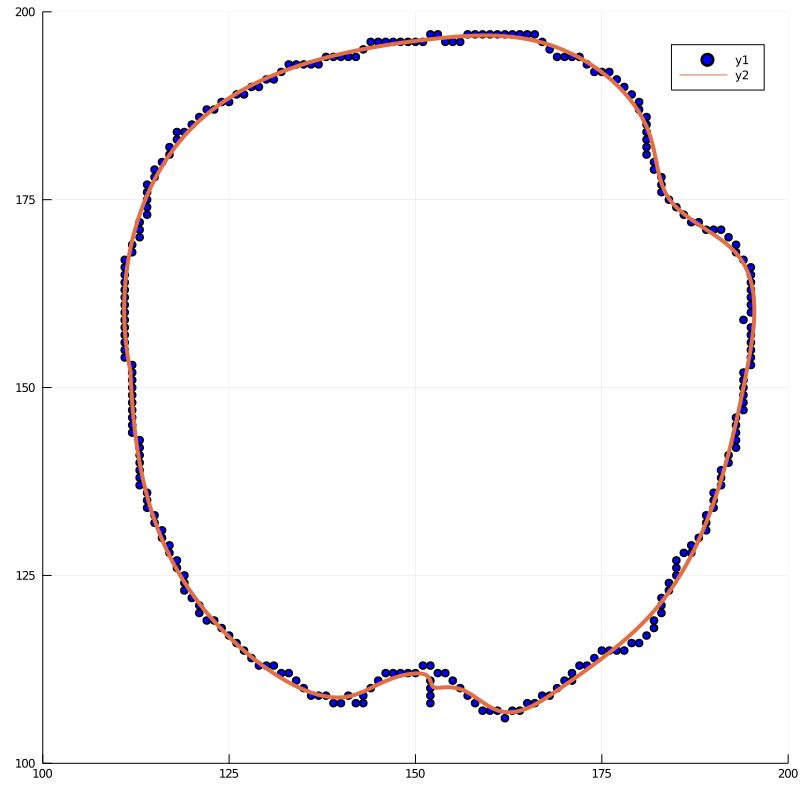

In [29]:
x = [i for (i,j) in stacked_layers]
y = [j for (i,j) in stacked_layers]
#scatter(x,y,size = (800, 800), color="red")
x = [i for (i,j) in edge]
y = [j for (i,j) in edge]
scatter(x,y,size = (800, 800), color="blue")
edge_spl_xy = edge_spl(range(0,1,length=10000))

#edge_spl_xy = edge_spl_xy[:, setdiff(1:end, (1:50...))]
#edge_spl_xy = edge_spl_xy[:, setdiff(1:end, (end-50:end...))]

#edge_spl_xy[:,end] = edge_spl_xy[:,1]

edge_spl_x = edge_spl_xy[1,:]
edge_spl_y = edge_spl_xy[2,:]
plot!(edge_spl_x,edge_spl_y,linewidth = 4,)
xlims!((100,200))
ylims!((100,200))

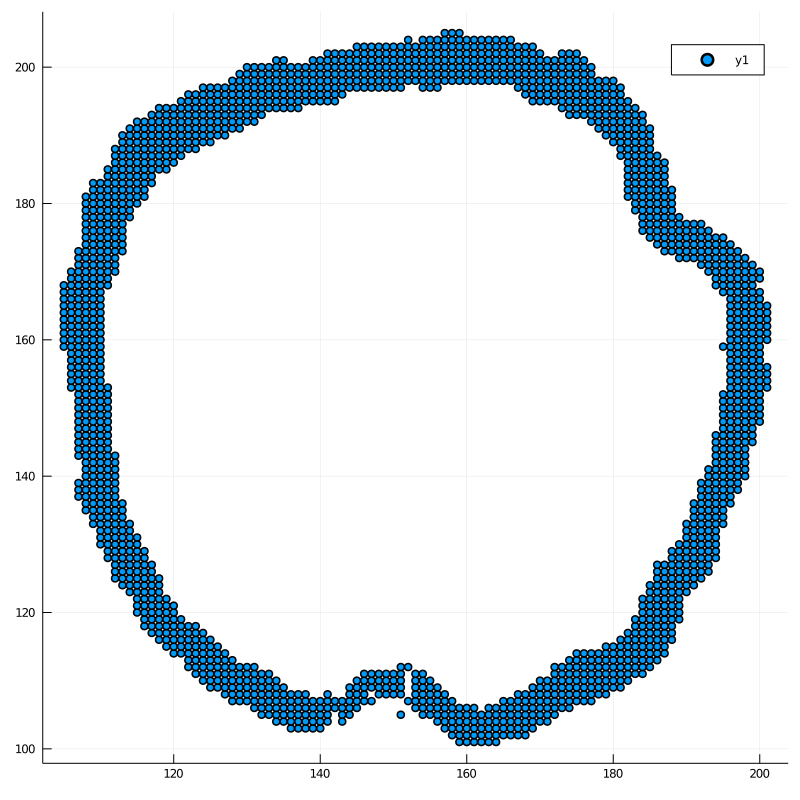

In [35]:
x = [i for (i,j) in layers[19]]
y = [j for (i,j) in layers[19]]
scatter(x,y,size = (800, 800))

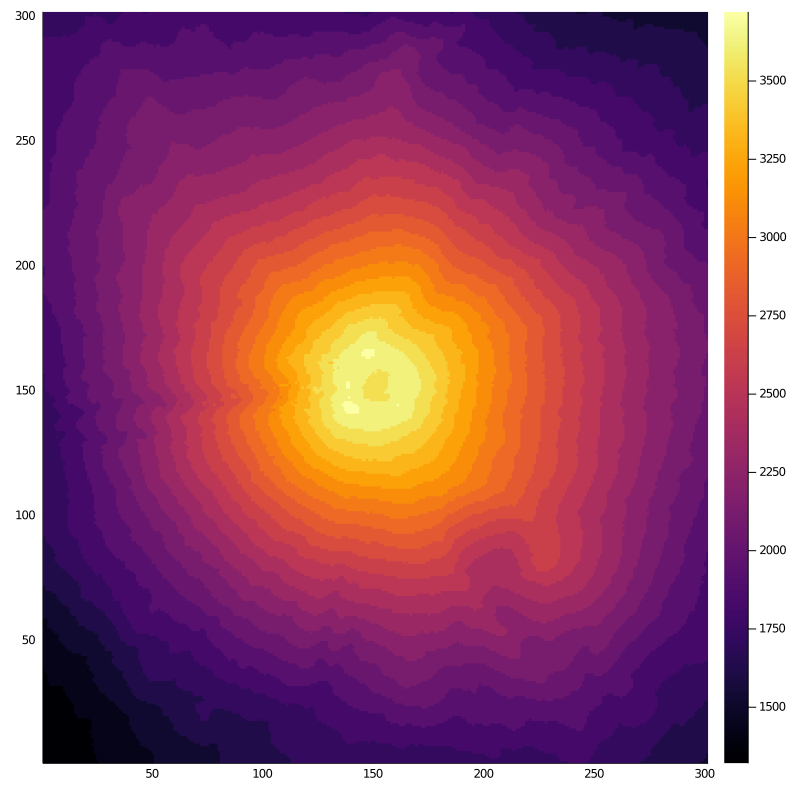

In [31]:
heatmap(sliced_data,
        size = (800, 800),
)

In [32]:
offset=convert(Float64,minimum(sliced_data)) - 10  # NaN occurs if offset equals the minimum value

mesh_triangles = get_mesh_triangles(sliced_data)
side_triangles = get_side_triangles(sliced_data,offset)
base_triangles = get_base_triangles(sliced_data,offset)


triangles = cat(base_triangles,cat(mesh_triangles,side_triangles,dims=1),dims=1)

println("Writing triangles to file...")
write_stl_binary("out.stl",triangles)
println("Done writing triangles to file...")

0.33%
0.67%
1.00%
1.33%
1.67%
2.00%
2.33%
2.67%
3.00%
3.33%
3.67%
4.00%
4.33%
4.67%
5.00%
5.33%
5.67%
6.00%
6.33%
6.67%
7.00%
7.33%
7.67%
8.00%
8.33%
8.67%
9.00%
9.33%
9.67%
10.00%
10.33%
10.67%
11.00%
11.33%
11.67%
12.00%
12.33%
12.67%
13.00%
13.33%
13.67%
14.00%
14.33%
14.67%
15.00%
15.33%
15.67%
16.00%
16.33%
16.67%
17.00%
17.33%
17.67%
18.00%
18.33%
18.67%
19.00%
19.33%
19.67%
20.00%
20.33%
20.67%
21.00%
21.33%
21.67%
22.00%
22.33%
22.67%
23.00%
23.33%
23.67%
24.00%
24.33%
24.67%
25.00%
25.33%
25.67%
26.00%
26.33%
26.67%
27.00%
27.33%
27.67%
28.00%
28.33%
28.67%
29.00%
29.33%
29.67%
30.00%
30.33%
30.67%
31.00%
31.33%
31.67%
32.00%
32.33%
32.67%
33.00%
33.33%
33.67%
34.00%
34.33%
34.67%
35.00%
35.33%
35.67%
36.00%
36.33%
36.67%
37.00%
37.33%
37.67%
38.00%
38.33%
38.67%
39.00%
39.33%
39.67%
40.00%
40.33%
40.67%
41.00%
41.33%
41.67%
42.00%
42.33%
42.67%
43.00%
43.33%
43.67%
44.00%
44.33%
44.67%
45.00%
45.33%
45.67%
46.00%
46.33%
46.67%
47.00%
47.33%
47.67%
48.00%
48.33%
48.67%
49.00%
